### Importing required Libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### Margin function to set a margin of 10% on the all four sides to remove Labels to avoid irrelevant things [ R, L, Name ]

In [3]:
def margin(img, margin_percent=10):
  h, w = img.shape
  margin_x = int(w * margin_percent / 100)
  margin_y = int(h * margin_percent / 100)
  cropped = img[margin_y:h-margin_y, margin_x:w-margin_x]
  return cropped

### KMeans Clustering used in image segmentation to partition xray_images into regions based on pixel similarities 

In [4]:
def process(img):
  flat_img = img.flatten().reshape(-1, 1)
  kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
  labels = kmeans.fit_predict(flat_img)
  centers = kmeans.cluster_centers_
  if np.mean(centers[1]) > np.mean(centers[0]):
    labels = 1 - labels
  clustered = np.reshape(labels, img.shape)
  clustered_binary = np.uint8(clustered * 255)
  return clustered_binary

### Filter Largest Contour in Image

* Thresholding: Convert the input image to a binary image using a threshold.
* Contour Detection: Find contours in the binary image.
* Contour Filtering: Select the largest contour based on area.
* Result Generation: Create a new image with the selected contour filled in.
* Return: Return the filtered image and the list of largest contours found.

In [5]:
def segment_and_filter(clustered_img):
  ret, thresh = cv2.threshold(clustered_img, 0, 255, cv2.THRESH_BINARY)
  if cv2.__version__[0] > '3':
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  else:
    _, contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  max_area = 0
  largest_contours = []
  for contour in contours:
    area = cv2.contourArea(contour)
    if area > max_area:
      max_area = area
      largest_contours.append(contour)
  
  result = np.zeros_like(clustered_img)
  cv2.drawContours(result, largest_contours, -1, 255, thickness=cv2.FILLED)
  return result, largest_contours

### Enhanced Image processing

* Read and convert the input image to grayscale.
* Crop the margins of the image.
* Process the cropped image (e.g., perform clustering).
* Segment and filter the processed image to get desired regions.
* Join the filtered region with its horizontally flipped version.

In [6]:
def process_image(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  cropped_img = margin(img)
  clustered_img = process(cropped_img)
  filtered_result, largest_contours = segment_and_filter(clustered_img)
  
  joined_image = cv2.hconcat([filtered_result[:, :filtered_result.shape[1] // 2],  
                  cv2.flip(filtered_result[:, :filtered_result.shape[1] // 2], 1)])
  
  return joined_image

def calculate_trapezium_area(top_width, bottom_width, height):
  area = 0.5 * (top_width + bottom_width) * height
  return area

### Define Trapezium & its Area

In [7]:
def calculate_trapezium_area(top_width, bottom_width, height):
  area = 0.5 * (top_width + bottom_width) * height
  return area

### Joining and fitting Trapezium to show the the total lungs area

* Convert the input image to color (RGB) format.
* Threshold the image to create a binary image.
* Find contours in the binary image.
* Sort the contours by area and select the two largest contours.
* Create a bounding rectangle around the combined two contours.
* Define the vertices of a trapezium based on the bounding rectangle.
* Draw the trapezium on the color image.
* Calculate and print the area of the trapezium.
* Return the color image with the plotted trapezium.

In [8]:
def detect_and_plot_trapezium(joined_image):
  color_image = cv2.cvtColor(joined_image, cv2.COLOR_GRAY2BGR)
  _, binary_image = cv2.threshold(joined_image, 1, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
  combined_rect = cv2.boundingRect(np.concatenate(contours))
  combined_rect = (combined_rect[0] - 20, combined_rect[1] - 20, combined_rect[2] + 40, combined_rect[3] + 40)

  combined_trapezium_pts = [[(combined_rect[0], combined_rect[1] + combined_rect[3])],
                [(combined_rect[0] + combined_rect[2], combined_rect[1] + combined_rect[3])],
                [(combined_rect[0] + combined_rect[2] * 0.75, combined_rect[1])],
                [(combined_rect[0] + combined_rect[2] * 0.25, combined_rect[1])]]

  # cv2.polylines(color_image, [np.array(combined_trapezium_pts, np.int32)], isClosed=True, color=(0, 0, 255), thickness=10)

  top_width = combined_rect[2] * 0.5
  bottom_width = combined_rect[2]
  height = combined_rect[3]
  area = calculate_trapezium_area(top_width, bottom_width, height)
  print("Area of the combined trapezium:", area)

  return color_image

### Image Path

In [9]:
image_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/normal/NORMAL2-IM-0297-0001.jpeg"

### Displaying Original and Processed Images with Trapezium plotting

Area of the combined trapezium: 1140588.0


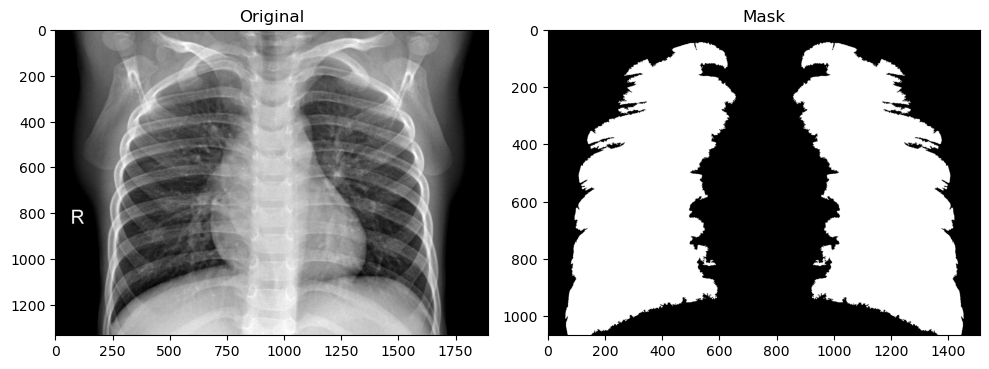

In [10]:
og_image = cv2.imread(image_path)
result_image = process_image(image_path)
result_image_with_trapezium = detect_and_plot_trapezium(result_image)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(cv2.cvtColor(og_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[0].axis('on')

axs[1].imshow(cv2.cvtColor(result_image_with_trapezium, cv2.COLOR_BGR2RGB))
axs[1].set_title('Mask')
axs[1].axis('on')

plt.tight_layout()
plt.show()

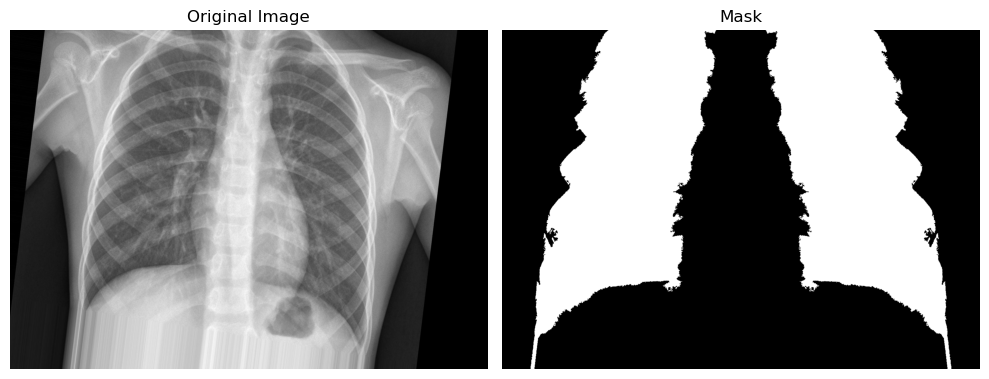

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Define image paths
image_path = r"C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/normal/aug_0_1297.jpeg"
mask_path = r"C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/mask/normal/aug_0_1297.jpeg"

# Load images
image = Image.open(image_path)
mask = Image.open(mask_path)

# Plot images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [12]:
# Save the result image with trapezium
output_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_with_trapezium.jpg"
cv2.imwrite(output_path, result_image_with_trapezium)

# Optionally print a confirmation message
print(f"Image saved to {output_path}")


Image saved to C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_with_trapezium.jpg


In [13]:
# Convert to binary using a threshold
_, binary_image = cv2.threshold(result_image_with_trapezium, 1, 255, cv2.THRESH_BINARY)

# Save the binary image
output_path_binary = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_with_trapezium_binary.jpg"
cv2.imwrite(output_path_binary, binary_image)

# Optionally print a confirmation message
print(f"Binary image saved to {output_path_binary}")


Binary image saved to C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_with_trapezium_binary.jpg


In [14]:
# # Check if binary_image is already 3-channel (i.e., has 3 channels)
# if len(binary_image.shape) == 2:  # If it is a single-channel image
#     binary_image_3channel = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
# else:
#     binary_image_3channel = binary_image  # It is already a 3-channel image

# # Ensure that the binary image has the same size as the original image
# binary_image_3channel_resized = cv2.resize(binary_image_3channel, (og_image.shape[1], og_image.shape[0]))

# # Create an alpha channel with the same size as the original image (with a transparency level)
# alpha = 0.5  # Adjust transparency level (0 is fully transparent, 1 is fully opaque)
# overlay = cv2.addWeighted(og_image, 1 - alpha, binary_image_3channel_resized, alpha, 0)

# # Save the final translucent image
# output_path_translucent = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_translucent_overlay.jpg"
# cv2.imwrite(output_path_translucent, overlay)

# # Optionally print a confirmation message
# print(f"Translucent overlay image saved to {output_path_translucent}")

# # Show the translucent overlay image using matplotlib
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
# ax.set_title('Translucent Overlay')
# ax.axis('on')
# plt.tight_layout()
# plt.show()


Translucent overlay image saved to C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_translucent_overlay.jpg


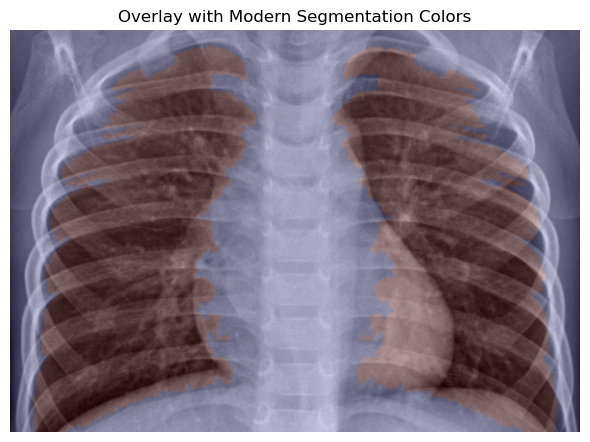

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths for input images
og_image_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/normal/NORMAL2-IM-0297-0001.jpeg"
binary_image_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_with_trapezium_binary.jpg"

# Load the original image
og_image = cv2.imread(og_image_path)
if og_image is None:
    print(f"Error: Unable to load the original image from path {og_image_path}")
    exit()

# Load the binary image (mask)
binary_image = cv2.imread(binary_image_path, cv2.IMREAD_GRAYSCALE)
if binary_image is None:
    print(f"Error: Unable to load the binary image from path {binary_image_path}")
    exit()

# -------------------------------
# 🔹 Apply Modern Segmentation Color Map
# -------------------------------
colored_mask = cv2.applyColorMap(binary_image, cv2.COLORMAP_JET)  # Modern, vibrant colormap

# Ensure the mask is the same size as the original image
colored_mask_resized = cv2.resize(colored_mask, (og_image.shape[1], og_image.shape[0]))

# -------------------------------
# 🔹 Zoom Only the Original Image
# -------------------------------
def zoom_image(image, zoom_factor=1.27):
    """
    Zooms into the center of the image by a given factor.
    :param image: Input image.
    :param zoom_factor: Factor by which to zoom in (>1 zooms in).
    :return: Zoomed-in image.
    """
    h, w = image.shape[:2]
    new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)
    
    # Compute the center crop region
    start_x, start_y = (w - new_w) // 2, (h - new_h) // 2
    cropped = image[start_y:start_y+new_h, start_x:start_x+new_w]
    
    # Resize back to original size
    zoomed = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)
    return zoomed

# Apply zoom to the original image
zoomed_og_image = zoom_image(og_image, zoom_factor=1.27)

# -------------------------------
# 🔹 Create Overlay
# -------------------------------
alpha = 0.2  # Adjust transparency (0 = fully transparent, 1 = fully opaque)
overlay = cv2.addWeighted(zoomed_og_image, 1 - alpha, colored_mask_resized, alpha, 0)

# Save the final translucent image
output_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_translucent_overlay.jpg"
cv2.imwrite(output_path, overlay)
print(f"Translucent overlay image saved to {output_path}")

# -------------------------------
# 🔹 Display Only Overlay Image
# -------------------------------
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Overlay with Modern Segmentation Colors')
plt.axis('off')  # Hide axes for better visualization
plt.tight_layout()
plt.show()


Translucent overlay image saved to C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_translucent_overlay.jpg


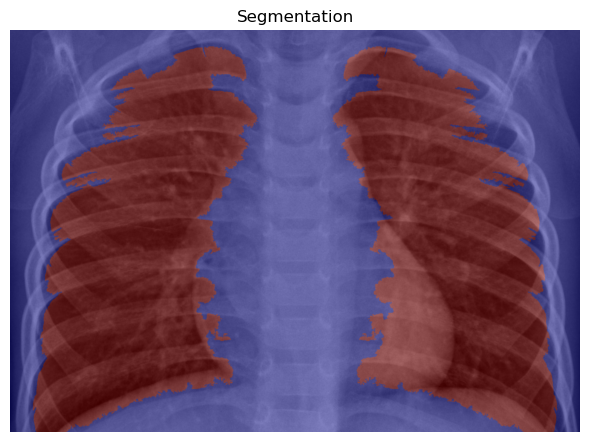

Cropped overlay from resized original image saved to C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/cropped_overlay_from_resized.jpg


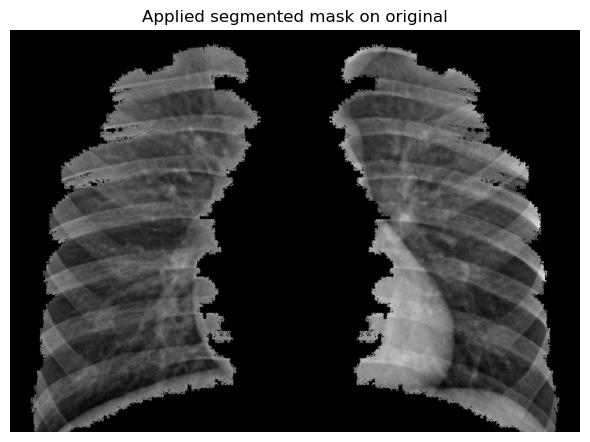

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths for input images
# og_image_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/normal/NORMAL2-IM-0297-0001.jpeg"
og_image_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/normal/NORMAL2-IM-0297-0001.jpeg"
binary_image_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_with_trapezium_binary.jpg"

# Load the original image
og_image = cv2.imread(og_image_path)
if og_image is None:
    print(f"Error: Unable to load the original image from path {og_image_path}")
    exit()

# Load the binary image (mask)
binary_image = cv2.imread(binary_image_path, cv2.IMREAD_GRAYSCALE)
if binary_image is None:
    print(f"Error: Unable to load the binary image from path {binary_image_path}")
    exit()

# -------------------------------
# 🔹 Apply Modern Segmentation Color Map
# -------------------------------
colored_mask = cv2.applyColorMap(binary_image, cv2.COLORMAP_JET)  # Modern, vibrant colormap

# Ensure the mask is the same size as the original image
colored_mask_resized = cv2.resize(colored_mask, (og_image.shape[1], og_image.shape[0]))

# -------------------------------
# 🔹 Zoom Only the Original Image
# -------------------------------
def zoom_image(image, zoom_factor=1.27):
    """
    Zooms into the center of the image by a given factor.
    :param image: Input image.
    :param zoom_factor: Factor by which to zoom in (>1 zooms in).
    :return: Zoomed-in image.
    """
    h, w = image.shape[:2]
    new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)
    
    # Compute the center crop region
    start_x, start_y = (w - new_w) // 2, (h - new_h) // 2
    cropped = image[start_y:start_y+new_h, start_x:start_x+new_w]
    
    # Resize back to original size
    zoomed = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)
    return zoomed

# Apply zoom to the original image
zoomed_og_image = zoom_image(og_image, zoom_factor=1.27)

# -------------------------------
# 🔹 Create Overlay
# -------------------------------
alpha = 0.5  # Adjust transparency (0 = fully transparent, 1 = fully opaque)
overlay = cv2.addWeighted(zoomed_og_image, 1 - alpha, colored_mask_resized, alpha, 0)

# Save the final translucent image
output_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_translucent_overlay.jpg"
cv2.imwrite(output_path, overlay)
print(f"Translucent overlay image saved to {output_path}")

# -------------------------------
# 🔹 Display Only Overlay Image
# -------------------------------
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Segmentation')
plt.axis('off')  # Hide axes for better visualization
plt.tight_layout()
plt.show()

# # -------------------------------
# # 🔹 Crop Non-overlay Parts (Fixing the Mask Size Issue)
# # -------------------------------
# # Convert the resized binary mask to a binary image (thresholding)
# _, binary_mask = cv2.threshold(binary_image, 1, 255, cv2.THRESH_BINARY)

# # Resize the binary mask to match the size of the zoomed image
# binary_mask_resized = cv2.resize(binary_mask, (zoomed_og_image.shape[1], zoomed_og_image.shape[0]))

# # Create a 3-channel mask from the binary mask for bitwise operations
# overlay_mask = cv2.merge([binary_mask_resized, binary_mask_resized, binary_mask_resized])

# # Apply the mask to the zoomed original image, keeping only the parts that are in the overlay region
# cropped_image = cv2.bitwise_and(zoomed_og_image, overlay_mask)

# # Save the cropped image
# cropped_output_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/cropped_overlay.jpg"
# cv2.imwrite(cropped_output_path, cropped_image)
# print(f"Cropped image with overlay saved to {cropped_output_path}")

# # Display cropped image
# plt.figure(figsize=(6, 6))
# plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
# plt.title('Cropped Overlay Region')
# plt.axis('off')  # Hide axes for better visualization
# plt.tight_layout()
# plt.show()

import cv2
import numpy as np
import matplotlib.pyplot as plt

import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 🔹 Crop Only the Overlay Region from Resized Original Image
# -------------------------------
# Convert the resized binary mask to a binary image (thresholding)
_, binary_mask = cv2.threshold(binary_image, 1, 255, cv2.THRESH_BINARY)

# Resize the binary mask to match the size of the zoomed original image
binary_mask_resized = cv2.resize(binary_mask, (zoomed_og_image.shape[1], zoomed_og_image.shape[0]))

# Create a new image where only the overlay region is visible
cropped_overlay_image = zoomed_og_image.copy()

# Set all areas where the mask is 0 (non-overlay areas) to black (0, 0, 0)
cropped_overlay_image[binary_mask_resized == 0] = [0, 0, 0]  # Black out non-overlay areas

# Save the cropped image with only the overlay regions
cropped_output_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/cropped_overlay_from_resized.jpg"
cv2.imwrite(cropped_output_path, cropped_overlay_image)
print(f"Cropped overlay from resized original image saved to {cropped_output_path}")

# Display the cropped image with overlay region
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(cropped_overlay_image, cv2.COLOR_BGR2RGB))
plt.title('Applied segmented mask on original')
plt.axis('off')  # Hide axes for better visualization
plt.tight_layout()
plt.show()



Translucent overlay image saved to C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_translucent_overlay.jpg


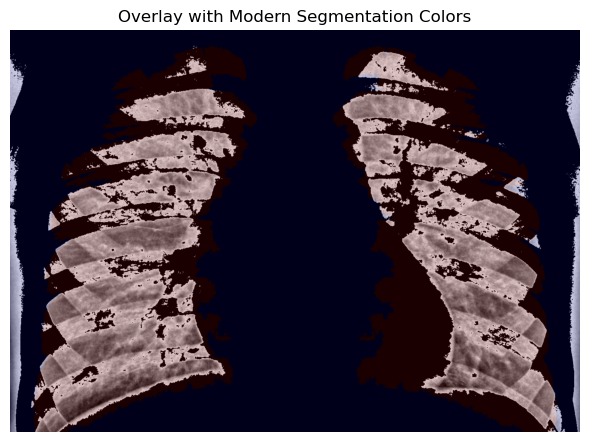

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths for input images
og_image_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/thresholded_images/image_0_threshold_90.png"
binary_image_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_with_trapezium_binary.jpg"

# Load the original image
og_image = cv2.imread(og_image_path)
if og_image is None:
    print(f"Error: Unable to load the original image from path {og_image_path}")
    exit()

# Load the binary image (mask)
binary_image = cv2.imread(binary_image_path, cv2.IMREAD_GRAYSCALE)
if binary_image is None:
    print(f"Error: Unable to load the binary image from path {binary_image_path}")
    exit()

# -------------------------------
# 🔹 Apply Modern Segmentation Color Map
# -------------------------------
colored_mask = cv2.applyColorMap(binary_image, cv2.COLORMAP_JET)  # Modern, vibrant colormap

# Ensure the mask is the same size as the original image
colored_mask_resized = cv2.resize(colored_mask, (og_image.shape[1], og_image.shape[0]))

# -------------------------------
# 🔹 Zoom Only the Original Image
# -------------------------------
def zoom_image(image, zoom_factor=1.27):
    """
    Zooms into the center of the image by a given factor.
    :param image: Input image.
    :param zoom_factor: Factor by which to zoom in (>1 zooms in).
    :return: Zoomed-in image.
    """
    h, w = image.shape[:2]
    new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)
    
    # Compute the center crop region
    start_x, start_y = (w - new_w) // 2, (h - new_h) // 2
    cropped = image[start_y:start_y+new_h, start_x:start_x+new_w]
    
    # Resize back to original size
    zoomed = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)
    return zoomed

# Apply zoom to the original image
zoomed_og_image = zoom_image(og_image, zoom_factor=1.27)

# -------------------------------
# 🔹 Create Overlay
# -------------------------------
alpha = 0.2  # Adjust transparency (0 = fully transparent, 1 = fully opaque)
overlay = cv2.addWeighted(zoomed_og_image, 1 - alpha, colored_mask_resized, alpha, 0)

# Save the final translucent image
output_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_translucent_overlay.jpg"
cv2.imwrite(output_path, overlay)
print(f"Translucent overlay image saved to {output_path}")

# -------------------------------
# 🔹 Display Only Overlay Image
# -------------------------------
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Overlay with Modern Segmentation Colors')
plt.axis('off')  # Hide axes for better visualization
plt.tight_layout()
plt.show()


Translucent overlay image saved to C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_translucent_overlay.jpg


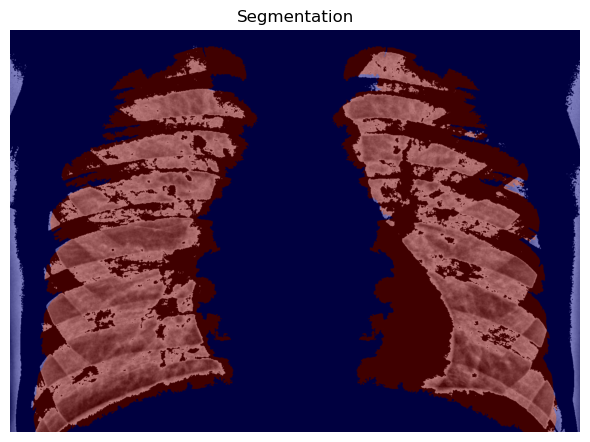

Cropped overlay from resized original image saved to C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/cropped_overlay_from_resized.jpg


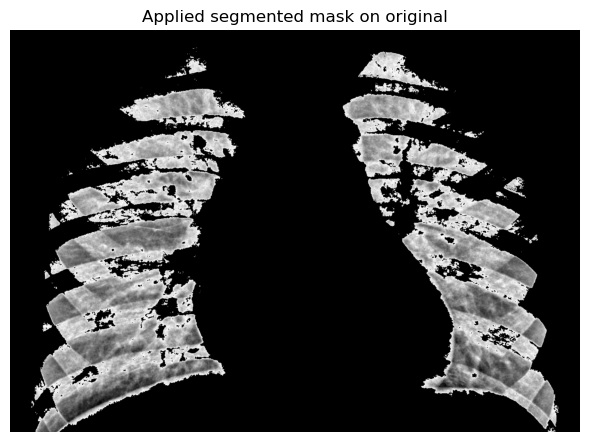

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths for input images
# og_image_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/normal/NORMAL2-IM-0297-0001.jpeg"
og_image_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/thresholded_images/image_0_threshold_90.png"
binary_image_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_with_trapezium_binary.jpg"

# Load the original image
og_image = cv2.imread(og_image_path)
if og_image is None:
    print(f"Error: Unable to load the original image from path {og_image_path}")
    exit()

# Load the binary image (mask)
binary_image = cv2.imread(binary_image_path, cv2.IMREAD_GRAYSCALE)
if binary_image is None:
    print(f"Error: Unable to load the binary image from path {binary_image_path}")
    exit()

# -------------------------------
# 🔹 Apply Modern Segmentation Color Map
# -------------------------------
colored_mask = cv2.applyColorMap(binary_image, cv2.COLORMAP_JET)  # Modern, vibrant colormap

# Ensure the mask is the same size as the original image
colored_mask_resized = cv2.resize(colored_mask, (og_image.shape[1], og_image.shape[0]))

# -------------------------------
# 🔹 Zoom Only the Original Image
# -------------------------------
def zoom_image(image, zoom_factor=1.27):
    """
    Zooms into the center of the image by a given factor.
    :param image: Input image.
    :param zoom_factor: Factor by which to zoom in (>1 zooms in).
    :return: Zoomed-in image.
    """
    h, w = image.shape[:2]
    new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)
    
    # Compute the center crop region
    start_x, start_y = (w - new_w) // 2, (h - new_h) // 2
    cropped = image[start_y:start_y+new_h, start_x:start_x+new_w]
    
    # Resize back to original size
    zoomed = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)
    return zoomed

# Apply zoom to the original image
zoomed_og_image = zoom_image(og_image, zoom_factor=1.27)

# -------------------------------
# 🔹 Create Overlay
# -------------------------------
alpha = 0.5  # Adjust transparency (0 = fully transparent, 1 = fully opaque)
overlay = cv2.addWeighted(zoomed_og_image, 1 - alpha, colored_mask_resized, alpha, 0)

# Save the final translucent image
output_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/result_translucent_overlay.jpg"
cv2.imwrite(output_path, overlay)
print(f"Translucent overlay image saved to {output_path}")

# -------------------------------
# Display Only Overlay Image
# -------------------------------
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Segmentation')
plt.axis('off')  # Hide axes for better visualization
plt.tight_layout()
plt.show()

# # -------------------------------
# # Crop Non-overlay Parts (Fixing the Mask Size Issue)
# # -------------------------------
# # Convert the resized binary mask to a binary image (thresholding)
# _, binary_mask = cv2.threshold(binary_image, 1, 255, cv2.THRESH_BINARY)

# # Resize the binary mask to match the size of the zoomed image
# binary_mask_resized = cv2.resize(binary_mask, (zoomed_og_image.shape[1], zoomed_og_image.shape[0]))

# # Create a 3-channel mask from the binary mask for bitwise operations
# overlay_mask = cv2.merge([binary_mask_resized, binary_mask_resized, binary_mask_resized])

# # Apply the mask to the zoomed original image, keeping only the parts that are in the overlay region
# cropped_image = cv2.bitwise_and(zoomed_og_image, overlay_mask)

# # Save the cropped image
# cropped_output_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/cropped_overlay.jpg"
# cv2.imwrite(cropped_output_path, cropped_image)
# print(f"Cropped image with overlay saved to {cropped_output_path}")

# # Display cropped image
# plt.figure(figsize=(6, 6))
# plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
# plt.title('Cropped Overlay Region')
# plt.axis('off')  # Hide axes for better visualization
# plt.tight_layout()
# plt.show()

import cv2
import numpy as np
import matplotlib.pyplot as plt

import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 🔹 Crop Only the Overlay Region from Resized Original Image
# -------------------------------
# Convert the resized binary mask to a binary image (thresholding)
_, binary_mask = cv2.threshold(binary_image, 1, 255, cv2.THRESH_BINARY)

# Resize the binary mask to match the size of the zoomed original image
binary_mask_resized = cv2.resize(binary_mask, (zoomed_og_image.shape[1], zoomed_og_image.shape[0]))

# Create a new image where only the overlay region is visible
cropped_overlay_image = zoomed_og_image.copy()

# Set all areas where the mask is 0 (non-overlay areas) to black (0, 0, 0)
cropped_overlay_image[binary_mask_resized == 0] = [0, 0, 0]  # Black out non-overlay areas

# Save the cropped image with only the overlay regions
cropped_output_path = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset/cropped_overlay_from_resized.jpg"
cv2.imwrite(cropped_output_path, cropped_overlay_image)
print(f"Cropped overlay from resized original image saved to {cropped_output_path}")

# Display the cropped image with overlay region
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(cropped_overlay_image, cv2.COLOR_BGR2RGB))
plt.title('Applied segmented mask on original')
plt.axis('off')  # Hide axes for better visualization
plt.tight_layout()
plt.show()



In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define paths
BASE_PATH = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/organized_dataset"
OUTPUT_PATH = "C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/mask"

# Ensure output directories exist
os.makedirs(os.path.join(OUTPUT_PATH, "normal"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "pneumonia"), exist_ok=True)

def margin(img, margin_percent=10):
    """Crop 10% margins from all sides."""
    h, w = img.shape
    margin_x = int(w * margin_percent / 100)
    margin_y = int(h * margin_percent / 100)
    return img[margin_y:h-margin_y, margin_x:w-margin_x]

def process(img):
    """Apply KMeans clustering for segmentation."""
    flat_img = img.flatten().reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
    labels = kmeans.fit_predict(flat_img)
    centers = kmeans.cluster_centers_
    
    if np.mean(centers[1]) > np.mean(centers[0]):
        labels = 1 - labels

    return np.reshape(labels, img.shape) * 255  # Convert to binary mask

def segment_and_filter(clustered_img):
    """Extract the largest contour as the lung region."""
    clustered_img = clustered_img.astype(np.uint8)

    _, thresh = cv2.threshold(clustered_img, 0, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    max_area = 0
    largest_contours = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contours.append(contour)

    result = np.zeros_like(clustered_img)
    cv2.drawContours(result, largest_contours, -1, 255, thickness=cv2.FILLED)
    return result


def process_image(image_path):
    """Process a single image."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Skipping {image_path}, unable to load image.")
        return None

    cropped_img = margin(img)
    clustered_img = process(cropped_img)
    filtered_result = segment_and_filter(clustered_img)

    # Mirror left lung to right lung
    half_width = filtered_result.shape[1] // 2
    mirrored_half = cv2.flip(filtered_result[:, :half_width], 1)
    joined_image = cv2.hconcat([filtered_result[:, :half_width], mirrored_half])

    return joined_image

def process_all_images():
    """Iterate through both folders and process all images."""
    for category in ["normal", "pneumonia"]:
        input_folder = os.path.join(BASE_PATH, category)
        output_folder = os.path.join(OUTPUT_PATH, category)

        for filename in os.listdir(input_folder):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(input_folder, filename)
                processed_image = process_image(image_path)

                if processed_image is not None:
                    output_path = os.path.join(output_folder, filename)
                    cv2.imwrite(output_path, processed_image)
                    # print(f"Saved: {output_path}")

# Run the processing function
process_all_images()
